In [1]:
!module list

Currently Loaded Modulefiles:
 1) singularity   2) openmpi/4.1.5   3) NCI-ai-ml/24.08   4) pbs  
>

In [2]:
from math import ceil
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import torch

import sys,os,time
wdir1="/g/data/z00/yxs900/neuraloperators/sfno/curriculum_learning/lowRes/experiments/05_LUCIE_rm_pos_embed/"
sys.path.append(wdir1)
from torch_harmonics_local_v2 import *
#from LUCIE_inference import inference

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    
device

device(type='cuda', index=0)

In [3]:
# used for lat,lon normalization
def generate_t30_grid():
    nlat = 48  # Number of latitudes
    nlon = 96  # Number of longitudes

    # Gaussian latitudes and weights
    latitudes, weights = np.polynomial.legendre.leggauss(nlat)
    latitudes = np.arcsin(latitudes) * (180.0 / np.pi)  # Convert to degrees

    # Longitudes
    longitudes = np.linspace(0, 360, nlon, endpoint=False)

    return latitudes, longitudes

def _minmax(img):
        return torch.as_tensor((img-img.min())/(img.max()-img.min()))

In [4]:
# modified to accept lat, lon channels
def inference(model, steps, initial_frame, forcing, initial_forcing_idx, prog_means, prog_stds, diag_means, diag_stds, diff_stds):
    inf_data = []
    inp_const =const_chans.to(device,dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        inp_val = initial_frame
        for i in range(steps):
            forcing_idx = (initial_forcing_idx + i) % 1460      # tisr is repeating and orography is 
            previous = inp_val[:,:5,:,:]
            inpc_val = torch.cat([inp_const, inp_val],dim=1)
            pred = model(inpc_val)
            pred[:,:5,:,:] = pred[:,:5,:,:] * diff_stds         # denormalize the predicted tendency

            # demornalzie the previous time step and add to the tendecy to reconstruct the current field
            pred[:,:5,:,:] += previous[:,:5,:,:] * prog_stds + prog_means

            tp_frame = pred[:,5:,:,:] * diag_stds + diag_means
            raw = torch.cat((pred[:,:5,:,:],tp_frame), 1)

            inp_val = (raw[:,:5,:,:] - prog_means) / prog_stds      # normalize the current time step for autoregressive prediction
            inp_val = torch.cat((inp_val, forcing[forcing_idx,:,:,:].reshape(1,2,48,96)), dim=1)
            raw = raw.cpu().clone().detach().numpy()
            inf_data.append(raw[0])

    inf_data = np.array(inf_data)
    inf_data[:,5,:,:] = (np.exp(inf_data[:,5,:,:]) - 1) * 1e-2      # denormalzie precipitation that was normalized in log space
    return inf_data

In [5]:
# load the ground truth for clim_bias from the original work
wdir="/g/data/z00/yxs900/neuraloperators/sfno/curriculum_learning/lowRes/experiments/03_LUCIE/"
data = load_data(f"{wdir}/LUCIE_fix/era5_T30_regridded.npz")[...,:6]
true_clim = torch.tensor(np.mean(data, axis=0)).to(device).permute(2,0,1)

In [6]:
# load the normalized inp, tar, and normalization scalars from the original work
data = np.load(f"{wdir}/LUCIE_fix/era5_T30_preprocessed.npz")     # standardized data with mean and stds generated from dataset_generator.py
data_inp = torch.tensor(data["data_inp"],dtype=torch.float32)     # input data 
data_tar = torch.tensor(data["data_tar"],dtype=torch.float32)
raw_means = torch.tensor(data["raw_means"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
raw_stds = torch.tensor(data["raw_stds"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
prog_means = raw_means[:,:5]
prog_stds = raw_stds[:,:5]
diag_means = torch.tensor(data["diag_means"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
diag_stds = torch.tensor(data["diag_stds"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
diff_means = torch.tensor(data["diff_means"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
diff_stds = torch.tensor(data["diff_stds"],dtype=torch.float32).reshape(1,-1,1,1).to(device)

In [7]:
lats, lons = generate_t30_grid()
lon2d, lat2d = np.meshgrid(lons, lats)
const_chans = _minmax(np.stack([_minmax(lat2d), _minmax(lon2d)])).unsqueeze(0)

In [8]:
# initialize the SFNO model
nlat = 48
nlon = 96
hard_thresholding_fraction = 0.9
cost, quad_weights = legendre_gauss_weights(nlat, -1, 1)
quad_weights = (torch.as_tensor(quad_weights).reshape(-1, 1)).to(device)

model = SphericalFourierNeuralOperatorNet(params = {}, spectral_transform='sht', filter_type = "linear", operator_type='dhconv', img_shape=(48, 96),num_layers=8, in_chans=9, out_chans=6, scale_factor=1, embed_dim=72, activation_function="silu", big_skip=True, pos_embed=False, use_mlp=True,normalization_layer="instance_norm", hard_thresholding_fraction=hard_thresholding_fraction,mlp_ratio = 2.).to(device)

#load checkpoint trained on Gadi

# avg training loss = 0.004622265231904475; best second year clim_bias = 17.084556579589844, 10y clim_bias = 18.0094
#path = torch.load(f'{wdir1}/checkpoints/141510460.gadi-pbs/lucie_268.pt')

# avg training loss = 0.004679288951551424; best second year clim_bias = 19.51044464111328; 10y clim_bias=27.0446
#path = torch.load(f'{wdir1}/checkpoints/141537889.gadi-pbs/lucie_219.pt')

# avg training loss = 0.004667891663633655; best second year clim_bias = 14.574235916137695, 10y clim_bias = 26.7252
path = torch.load(f'{wdir1}/checkpoints/141688343.gadi-pbs/lucie_193.pt')
model.load_state_dict(path["model_state_dict"])

# run rollout for 10 years
forcing = data_inp[:1460,-2:]   # repeating tisr and constant oro
rollout_step = 14600
initial_frame_idx = 16000+100
forcing_initial_idx = (16000+100) % 1460 + 1
rollout = inference(model, rollout_step, data_inp[initial_frame_idx].unsqueeze(0).to(device), forcing.to(device), forcing_initial_idx, prog_means, prog_stds, diag_means, diag_stds, diff_stds)
print(rollout.shape)

(14600, 6, 48, 96)


# Check the Spatial Pattern

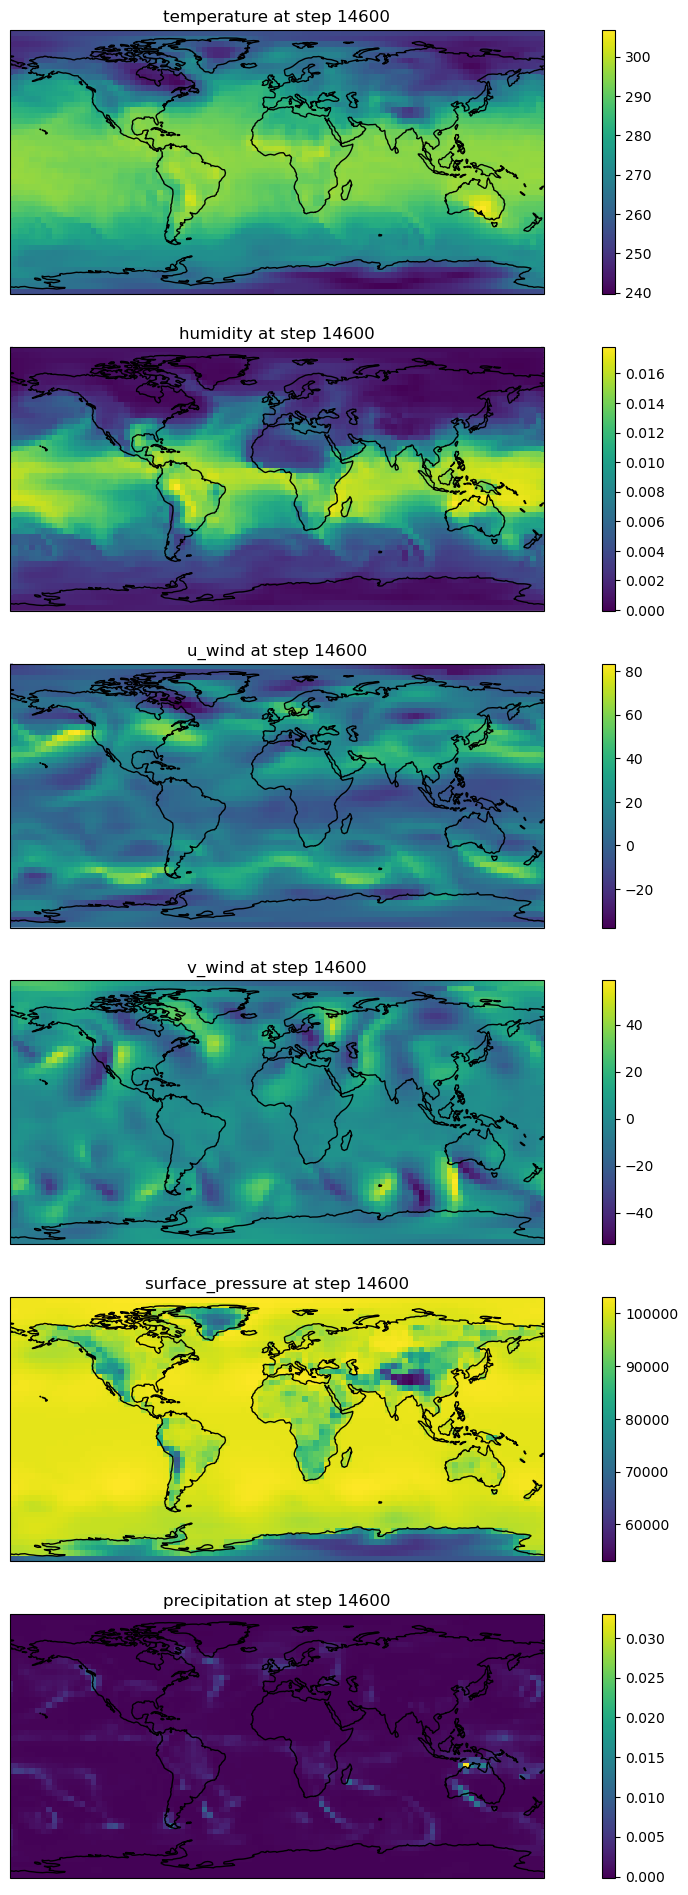

In [9]:
w,h = 5,4
vars = ['temperature', 'humidity', 'u_wind', 'v_wind', 'surface_pressure', 'precipitation']
nvars=len(vars)

fig,axs = plt.subplots(nvars,1, figsize=(3*w,h*nvars),subplot_kw={'projection': ccrs.PlateCarree()},squeeze=False)
for ii in range(nvars):
    pcm = axs[ii,0].pcolormesh(lon2d,lat2d,rollout[-1,ii,:,:])
    axs[ii,0].coastlines()
    axs[ii,0].set_title(f"{vars[ii]} at step {rollout.shape[0]}")
    fig.colorbar(pcm, ax=axs[ii,0])

# Check Climate Bias

In [10]:
# mean clim_bias between year 1 and 10, it is expected to be different from what reported in the training 
rollout_clim = torch.mean(torch.tensor(rollout[1460:]).to(device),dim=0)
clim_bias = torch.mean(torch.abs(rollout_clim - true_clim))
clim_bias

tensor(26.7252, device='cuda:0')

In [11]:
# relative clim_bias by vars
#using 141688343.gadi-pbs/lucie_193.pt
# this should be comparable to the list reported in replicate/LUCIE_Gadi/LUCIE_AR.ipynb
# removing pos_embed can result in higher clim_bias
rel_clim_bias = torch.mean(torch.abs((rollout_clim - true_clim)/true_clim),dim=(-2,-1))
list(zip(vars,rel_clim_bias.tolist()))

[('temperature', 0.0014328230172395706),
 ('humidity', 0.08715122193098068),
 ('u_wind', 1.9514261484146118),
 ('v_wind', 3.22937273979187),
 ('surface_pressure', 0.0017465344863012433),
 ('precipitation', 0.1567429006099701)]

# Compare Global Mean over Time

In [12]:
data = load_data(f"{wdir}/LUCIE_fix/era5_T30_regridded.npz")[...,:6]
true_clim_t = np.mean(data[1460:14600], axis=(1,2))
pred = torch.tensor(rollout[1460:]).detach()
pred_clim_t = torch.mean(pred,dim=(-1,-2))

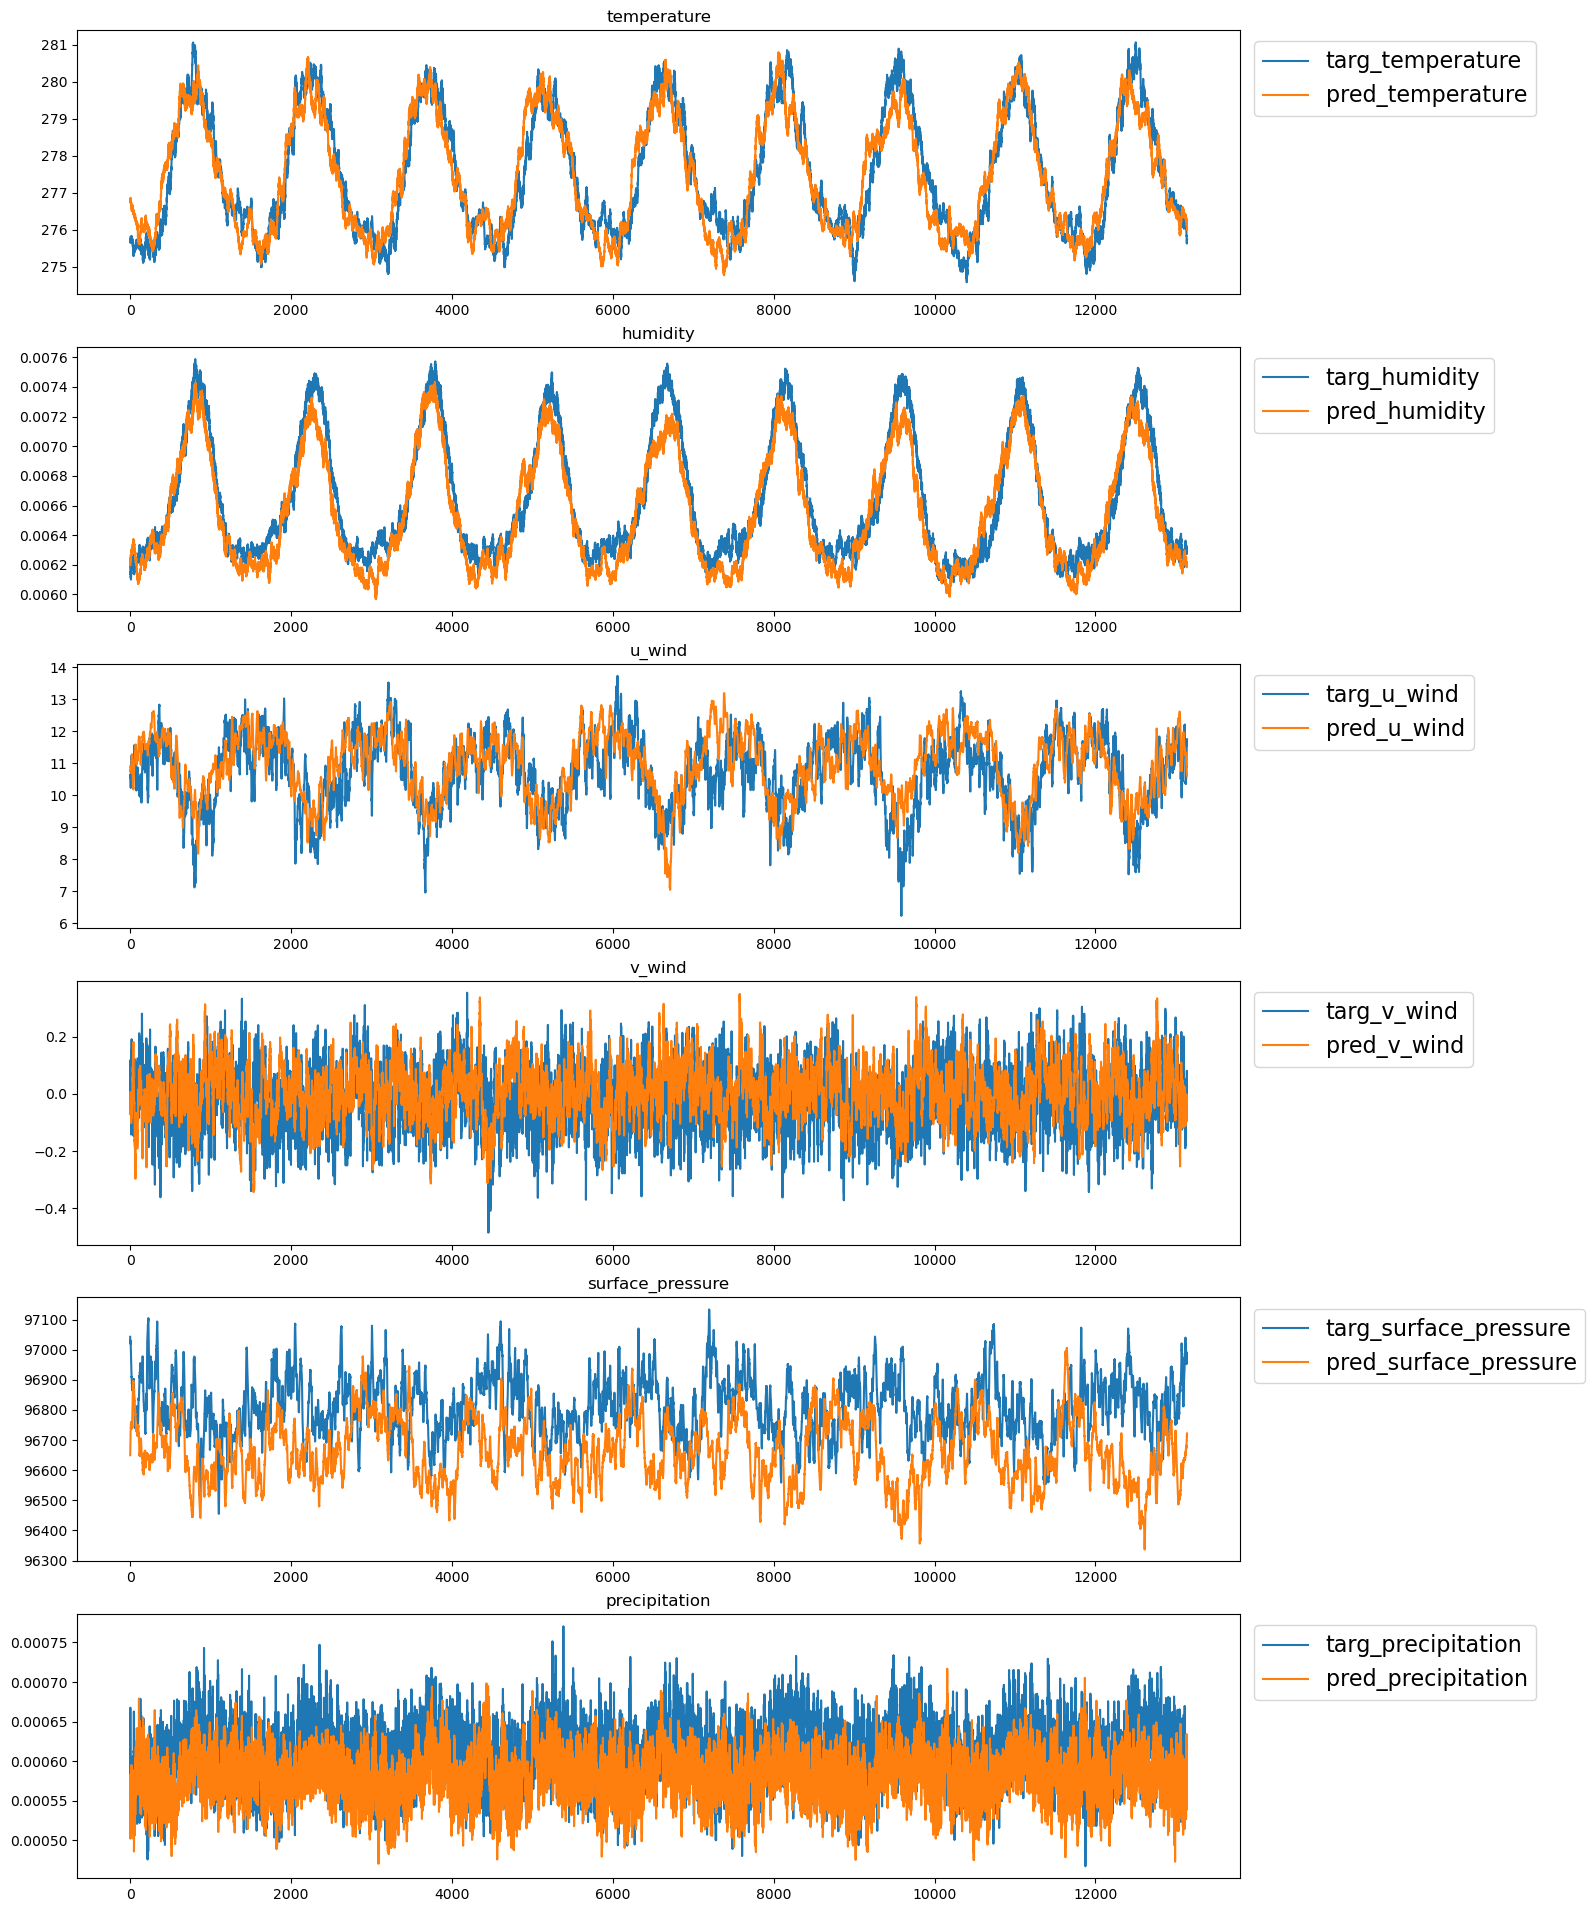

In [13]:
fig,axs = plt.subplots(nvars,1, figsize=(w*3,h*nvars))
for ii in range(nvars):
    pcm1 = axs[ii].plot(true_clim_t[:,ii],label=f"targ_{vars[ii]}")
    pcm2 = axs[ii].plot(pred_clim_t[:,ii],label=f"pred_{vars[ii]}")
    axs[ii].set_title(f"{vars[ii]}")
    axs[ii].legend(loc='upper left', bbox_to_anchor=(1.003, 1),fontsize=16)

# The END